In [2]:
import os

path = "C:/Users/user/Desktop/CV_LD/Day_049-050"
os.chdir(path)

In [3]:
import os
if not os.path.exists("keras-yolo3/model_data/yolo.h5"):
    # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
    print("Model doesn't exist, downloading...")
    os.system("wget https://pjreddie.com/media/files/yolov3.weights")
    print("Converting yolov3.weights to yolo.h5...")
    os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
    print("done...")
else:
    print("Model exist")

Model exist


In [ ]:
if not os.path.exists("2020_train.txt"):
    # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd

    sets=[('2020', 'train'), ('2020', 'val')]

  # 資料類別
    classes = ["kangaroo","raccoon"]

# 把 annotation 轉換訓練時需要的資料形態
# open('kangaroo_image/annots/%s.xml'%(image_id)) kangaroo path 

    def convert_annotation(image_id, list_file):
        in_file = open('kangaroo_image/annots/%s.xml'%(image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()
        
        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in classes or int(difficult)==1:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))
    wd = "."

    #kangaroo
    for year, image_set in sets:
        image_ids = open('kangaroo_image/kangaroo_%s.txt'%(image_set)).read().strip().split()
        annotation_path = 'kangaroo_run_%s.txt'%(image_set) #kangaroo image 資訊
        list_file = open(annotation_path, 'w')
        print("save annotation at %s" % annotation_path)
        miss_images = [8,15,35,57,58,63,67,68,70,82,104,106,126,133,135,138,142,160,165]
        
        
        for image_id in image_ids[:184]: #In fact only 164 kangaroo images inside
            print('write images ',image_id,'...')
            if image_id in miss_images:  #數據有遺失，需跳過部分images
                print('miss')
                continue
            else:
                list_file.write('%s/kangaroo_image/images/%s.jpg'%(wd, image_id))
                convert_annotation(image_id, list_file)
                list_file.write('\n')
                print('done.')
        list_file.close()
#--------------------------------------------------------------------------------------------------      
    #raccon
    def convert_annotation_raccoon(image_id, list_file):
        in_file = open('raccoon_image/annotations/raccoon-%s.xml'%(image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()
        
        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in classes or int(difficult)==1:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))
    
    
    for year, image_set in sets:
        image_ids = open('raccoon_image/raccoon_%s.txt'%(image_set)).read().strip().split()
        annotation_path = 'raccoon_run_%s.txt'%(image_set) #kangaroo image 資訊
        list_file = open(annotation_path, 'w')
        print("save annotation at %s" % annotation_path)
        
        
        for image_id in image_ids[:200]: #In fact only 164 kangaroo images inside
            print('write images ',image_id,'...')
            list_file.write('%s/raccoon_image/images/raccoon-%s.jpg'%(wd, image_id))
            convert_annotation_raccoon(image_id, list_file)
            list_file.write('\n')
            print('done.')
        list_file.close()
           

In [ ]:
#combin two file that kangaroo、raccon training.txt and val.txt.
#training: 2020_train.txt include 291 images
#val: 2020_val.txt include 73 images

#training
fn_train = '2020_train.txt' 
fn_val = '2020_val.txt'
kangaroo_ls = []
raccoon_ls = []
with open('kangaroo_run_train.txt') as read_train:
    for l in read_train:
        kangaroo_ls.append(l.rstrip()) #save file info as each line (131)
        
with open('raccoon_run_train.txt') as read_train:
    for l in read_train:
        raccoon_ls.append(l.rstrip()) #save file info as each line (160)
    
with open(fn_train,'w') as save_train:
    for r_k in range(131):
        save_train.write(kangaroo_ls[r_k]+'\n')
    for r_r in range(160):
        save_train.write(raccoon_ls[r_r]+'\n')
        
#val --------------------------------------------------------------------------------------------   
kangaroo_ls.clear() #clear list of kangaroo and raccoon
raccoon_ls.clear()

with open('kangaroo_run_val.txt') as read_train:
    for l in read_train:
        kangaroo_ls.append(l.rstrip()) #save file info as each line (33)
        
with open('raccoon_run_val.txt') as read_train:
    for l in read_train:
        raccoon_ls.append(l.rstrip()) #save file info as each line (40)
    
with open(fn_val,'w') as save_train:
    for r_k in range(33):
        save_train.write(kangaroo_ls[r_k]+'\n')
    for r_r in range(40):
        save_train.write(raccoon_ls[r_r]+'\n')



In [4]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.
C:\Users\user\Anaconda3\envs\NEW_2020_02_17\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\envs\NEW_2020_02_17\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\envs\NEW_2020_02_17\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3

In [5]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [6]:
if not os.path.exists("keras-yolo3/model_data/yolo_weights.h5"):
    print("Converting pretrained YOLOv3 weights for training")
    os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Pretrained weights exists


In [7]:
annotation_path = '2020_train.txt' # 轉換好格式的標註檔案
log_dir = 'keras-yolo3/logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'keras-yolo3/model_data/voc_classes.txt'
anchors_path = 'keras-yolo3/model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='keras-yolo3/model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='keras-yolo3/logs/000/keras-yolo3/model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1 #這裡有點問題，以程式的意思是指將train的數據做切分，但是我們已經分好train和val，反而val的數據用不到。
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
print('num_val:',num_val)
num_train = len(lines) - num_val
print('num_train',num_train)

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train

if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 32
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=700,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.

# if True:
#     # 把所有 layer 都改為 trainable ，共有255個被unfreeze
#     for i in range(len(model.layers)):
#         #print('freeze:'+str(i))
#         model.layers[i].trainable = True
#     model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
#     print('Unfreeze all of the layers.')

#     batch_size = 4 # note that more GPU memory is required after unfreezing the body
#     print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
#     model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
#         steps_per_epoch=max(1, num_train//batch_size),
#         validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
#         validation_steps=max(1, num_val//batch_size),
#         epochs=100,
#         initial_epoch=50,
#         callbacks=[logging, checkpoint, reduce_lr])  #, early_stopping
#     model.save_weights(log_dir + 'trained_weights_final.h5')
    









Create YOLOv3 model with 9 anchors and 2 classes.
Load weights keras-yolo3/logs/000/ep477-loss22.910-val_loss20.021.h5.
Freeze the first 249 layers of total 252 layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
num_val: 36
num_train 328

Train on 328 samples, val on 36 samples, with batch size 32.


Epoch 1/700
10/10 [==============================] - 33s 3s/step - loss: 22.4986 - val_loss: 22.1643
Epoch 2/700
10/10 [==============================] - 26s 3s/step - loss: 22.1006 - val_loss: 19.6104
Epoch 3/700
10/10 [==============================] - 27s 3s/step - loss: 21.3597 - val_loss: 19.9460
Epoch 4/700
10/10 [==============================] - 9s 905ms/step - loss: 20.7827 - val_loss: 19.2841
Epoch 5/700
10/10 [==============================] - 26s 3s/step - loss: 20.2996 - val_loss: 18.9380
Epoch 6/700
10/10 [==============================] - 26s 3s/step - loss: 20.1306 - val_loss: 18.0754
Epoch 7/700
10/10 [=============

Epoch 54/700
10/10 [==============================] - 26s 3s/step - loss: 16.4437 - val_loss: 16.0124
Epoch 55/700
10/10 [==============================] - 26s 3s/step - loss: 16.3068 - val_loss: 15.3467
Epoch 56/700
10/10 [==============================] - 26s 3s/step - loss: 16.4737 - val_loss: 15.5903
Epoch 57/700
10/10 [==============================] - 26s 3s/step - loss: 16.2960 - val_loss: 15.3158
Epoch 58/700
10/10 [==============================] - 26s 3s/step - loss: 15.9236 - val_loss: 15.1798
Epoch 59/700
10/10 [==============================] - 26s 3s/step - loss: 16.6876 - val_loss: 15.7089
Epoch 60/700
10/10 [==============================] - 26s 3s/step - loss: 16.5305 - val_loss: 15.0790
Epoch 61/700
10/10 [==============================] - 27s 3s/step - loss: 16.1117 - val_loss: 16.4259
Epoch 62/700
10/10 [==============================] - 26s 3s/step - loss: 16.4016 - val_loss: 15.5963
Epoch 63/700
10/10 [==============================] - 26s 3s/step - loss: 16.0360 

Epoch 134/700
10/10 [==============================] - 26s 3s/step - loss: 15.5881 - val_loss: 15.7782
Epoch 135/700
10/10 [==============================] - 26s 3s/step - loss: 15.9068 - val_loss: 15.0128
Epoch 136/700
10/10 [==============================] - 26s 3s/step - loss: 15.8424 - val_loss: 15.9937
Epoch 137/700
10/10 [==============================] - 26s 3s/step - loss: 15.6302 - val_loss: 15.3524
Epoch 138/700
10/10 [==============================] - 26s 3s/step - loss: 15.7324 - val_loss: 15.5676
Epoch 139/700
10/10 [==============================] - 26s 3s/step - loss: 16.0069 - val_loss: 16.5027
Epoch 140/700
10/10 [==============================] - 26s 3s/step - loss: 15.8087 - val_loss: 15.5689
Epoch 141/700
10/10 [==============================] - 26s 3s/step - loss: 16.1758 - val_loss: 14.9605
Epoch 142/700
10/10 [==============================] - 26s 3s/step - loss: 15.3797 - val_loss: 14.8917
Epoch 143/700
10/10 [==============================] - 26s 3s/step - loss

10/10 [==============================] - 26s 3s/step - loss: 15.5855 - val_loss: 14.4803
Epoch 293/700
10/10 [==============================] - 26s 3s/step - loss: 15.1621 - val_loss: 14.9277
Epoch 294/700
10/10 [==============================] - 26s 3s/step - loss: 15.5915 - val_loss: 15.6468
Epoch 295/700
10/10 [==============================] - 26s 3s/step - loss: 15.3533 - val_loss: 14.7156
Epoch 296/700
10/10 [==============================] - 26s 3s/step - loss: 15.1853 - val_loss: 14.5775
Epoch 297/700
10/10 [==============================] - 26s 3s/step - loss: 15.4315 - val_loss: 15.5836
Epoch 298/700
10/10 [==============================] - 26s 3s/step - loss: 14.9152 - val_loss: 15.0984
Epoch 299/700
10/10 [==============================] - 26s 3s/step - loss: 15.6972 - val_loss: 15.1441
Epoch 300/700
10/10 [==============================] - 26s 3s/step - loss: 15.1460 - val_loss: 14.8937
Epoch 301/700
10/10 [==============================] - 26s 3s/step - loss: 15.5838 - va

10/10 [==============================] - 26s 3s/step - loss: 15.0529 - val_loss: 15.1352
Epoch 451/700
10/10 [==============================] - 26s 3s/step - loss: 15.0105 - val_loss: 14.4003
Epoch 452/700
10/10 [==============================] - 26s 3s/step - loss: 15.0026 - val_loss: 15.6873
Epoch 453/700
10/10 [==============================] - 29s 3s/step - loss: 15.1602 - val_loss: 14.5915
Epoch 454/700
10/10 [==============================] - 26s 3s/step - loss: 14.8270 - val_loss: 14.7845
Epoch 455/700
10/10 [==============================] - 26s 3s/step - loss: 15.0430 - val_loss: 15.5422
Epoch 456/700
10/10 [==============================] - 27s 3s/step - loss: 15.2426 - val_loss: 14.6594
Epoch 457/700
10/10 [==============================] - 26s 3s/step - loss: 15.3276 - val_loss: 14.5425
Epoch 458/700
10/10 [==============================] - 26s 3s/step - loss: 14.9974 - val_loss: 14.3769
Epoch 459/700
10/10 [==============================] - 27s 3s/step - loss: 15.2006 - va

10/10 [==============================] - 26s 3s/step - loss: 14.6840 - val_loss: 14.1061
Epoch 609/700
10/10 [==============================] - 26s 3s/step - loss: 14.9384 - val_loss: 14.7006
Epoch 610/700
10/10 [==============================] - 26s 3s/step - loss: 14.7782 - val_loss: 14.5485
Epoch 611/700
10/10 [==============================] - 27s 3s/step - loss: 15.1149 - val_loss: 14.1200
Epoch 612/700
10/10 [==============================] - 27s 3s/step - loss: 14.8317 - val_loss: 14.8445
Epoch 613/700
10/10 [==============================] - 26s 3s/step - loss: 14.7562 - val_loss: 14.7628
Epoch 614/700
10/10 [==============================] - 26s 3s/step - loss: 14.8336 - val_loss: 14.5772
Epoch 615/700
10/10 [==============================] - 26s 3s/step - loss: 15.1316 - val_loss: 15.1366
Epoch 616/700
10/10 [==============================] - 27s 3s/step - loss: 14.7896 - val_loss: 14.1653
Epoch 617/700
10/10 [==============================] - 26s 3s/step - loss: 14.8671 - va

In [10]:
from PIL import Image
image_1 = Image.open('kangaroo.jpg')
image_2 = Image.open('raccoon.jpg') 
image_3 = Image.open('raccoon2.jpg')
image_4 = Image.open('elephant.jpg')
image_5 = Image.open('kangaroo2.jpg')
image_6 = Image.open('kangaroo3.jpg')
image_7 = Image.open('raccoon3.jpg')
image_8 = Image.open('horse.png')
#image_9 = Image.open('kangaroo2.jpg')

In [11]:
from yolo import YOLO
yolo_model = YOLO(model_path='keras-yolo3/logs/000/ep543-loss15.076-val_loss13.529.h5', classes_path="keras-yolo3/model_data/voc_classes.txt",anchors_path="keras-yolo3/model_data/yolo_anchors.txt")
r_image_1 = yolo_model.detect_image(image_1) #kangaroo
r_image_2 = yolo_model.detect_image(image_2) #raccoon
r_image_3 = yolo_model.detect_image(image_3) #raccoon
r_image_4 = yolo_model.detect_image(image_4) #elephant
r_image_5 = yolo_model.detect_image(image_5) #kanagroo
r_image_6 = yolo_model.detect_image(image_6) #kanagroo
r_image_7 = yolo_model.detect_image(image_7) #raccoon
r_image_8 = yolo_model.detect_image(image_8) #horse

keras-yolo3/logs/000/ep543-loss15.076-val_loss13.529.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.65 (204, 39) (298, 127)
kangaroo 0.68 (109, 55) (201, 155)
kangaroo 0.84 (6, 39) (114, 130)
1.8047821000000113
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (0, 18) (277, 169)
0.05223570000089239
(416, 416, 3)
Found 2 boxes for img
raccoon 0.85 (253, 13) (853, 511)
kangaroo 0.61 (223, 10) (945, 506)
0.0692008000005444
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (28, 70) (53, 102)
kangaroo 0.42 (69, 49) (250, 150)
0.057531599999492755
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.77 (134, 130) (401, 363)
kangaroo 0.86 (286, 0) (669, 531)
0.06813359999796376
(416, 416, 3)
Found 2 boxes for img
raccoon 0.91 (29, 17) (222, 212)
kangaroo 0.31 (43, 22) (186, 206)
0.053888000002189074
(416, 416, 3)
Found 2 boxes for img
raccoon 0.69 (38, 10) (145, 177)
raccoon 0.89 (99, 9) (214, 183)
0.053346199998486554
(416, 416, 3)
Found 0 boxes for img
0.060

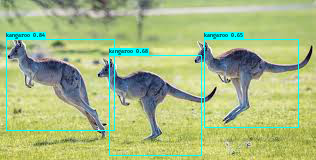

In [12]:
r_image_1

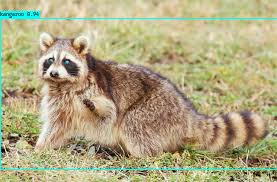

In [13]:
r_image_2

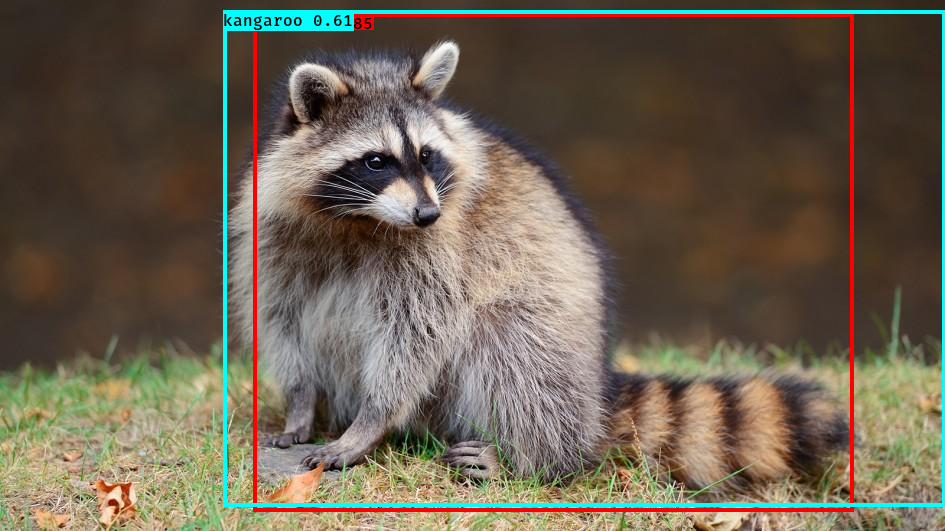

In [14]:
r_image_3

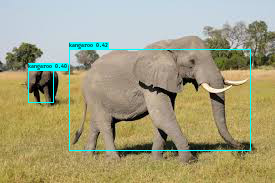

In [15]:
r_image_4

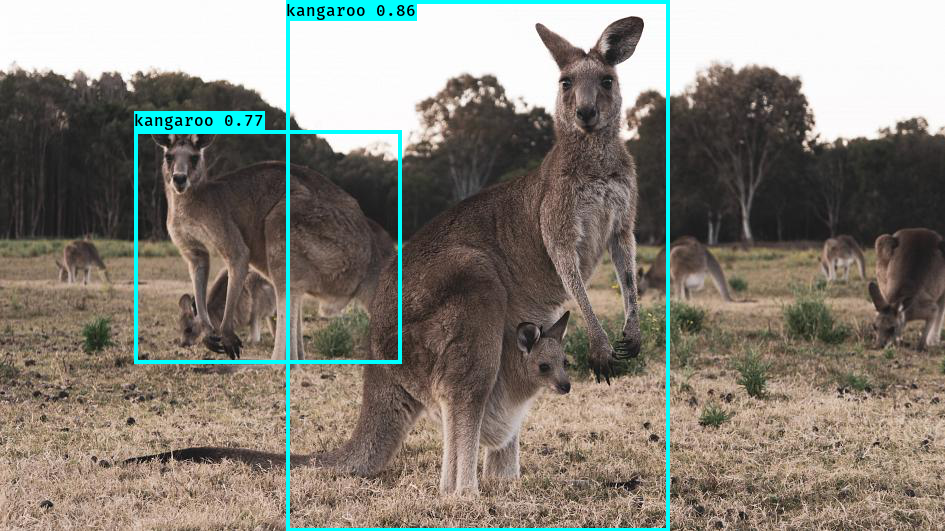

In [16]:
r_image_5

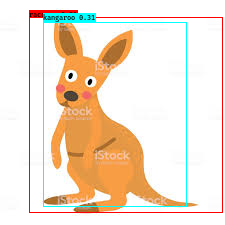

In [17]:
r_image_6

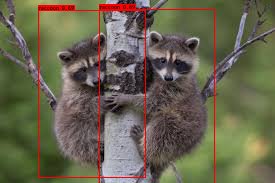

In [18]:
r_image_7

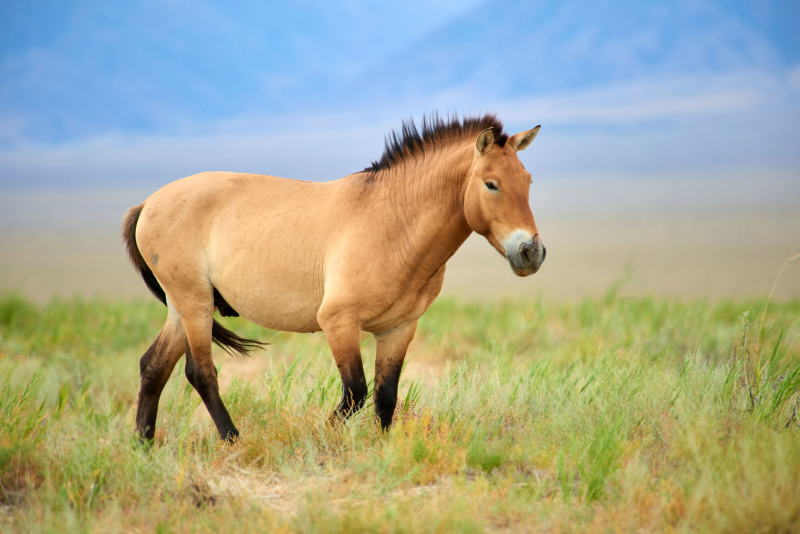

In [19]:
r_image_8